In [27]:
import os
import json
import glob
import warnings
import numpy as np
import xarray as xr
import proplot as pplt
import matplotlib.ticker as mticker
warnings.filterwarnings('ignore')
pplt.rc.update({'fontsize':12,'reso':'xx-hi','figure.dpi':100})

In [22]:
with open('/global/cfs/cdirs/m4334/sferrett/monsoon-kernels/scripts/configs.json','r',encoding='utf-8') as f:
    CONFIGS = json.load(f)
SPLITSDIR  = CONFIGS['filepaths']['splits']
WEIGHTSDIR = CONFIGS['filepaths']['weights']
MODELS     = CONFIGS['models']
SPLIT      = 'test'

In [23]:
with xr.open_dataset(f'{SPLITSDIR}/{SPLIT}.h5', engine='h5netcdf') as ds:
    lev = ds['lev'].load()

results = {}
for model in MODELS:
    name = model['name']
    if 'kernel' not in name:
        continue
    filepath = os.path.join(WEIGHTSDIR,f'{name}_{SPLIT}_weights.nc')
    if not os.path.exists(filepath):
        continue
    with xr.open_dataset(filepath,engine='h5netcdf') as ds:
        if ('k1' in ds) and ('k2' in ds):
            k1,k2 = ds['k1'].load(),ds['k2'].load()
            k1mean,k2mean = k1.mean('seed'),k2.mean('seed')
            k1std,k2std   = k1.std('seed'),k2.std('seed')
            results[name] = dict(kind='mixture',mean1=k1mean,std1=k1std,mean2=k2mean,std2=k2std)
        else:
            k     = ds['k'].load()
            kmean = k.mean('seed')
            kstd  = k.std('seed')
            results[name] = dict(kind='single',mean=kmean,std=kstd)

print(f'Found {len(results)} kernel models with saved weights!')

Found 5 kernel models with saved weights!


In [24]:
families   = [('nonparametric','Nonparametric'),
              ('gaussian','Gaussian'),
              ('mixgaussian','Mixed Gaussian'),
              ('exponential','Exponential'),
              ('tophat','Top Hat')]
rowlabels   = ['RH',r'$\theta_e$',r'$\theta_e^*$']
nrows,ncols = 3,len(families)

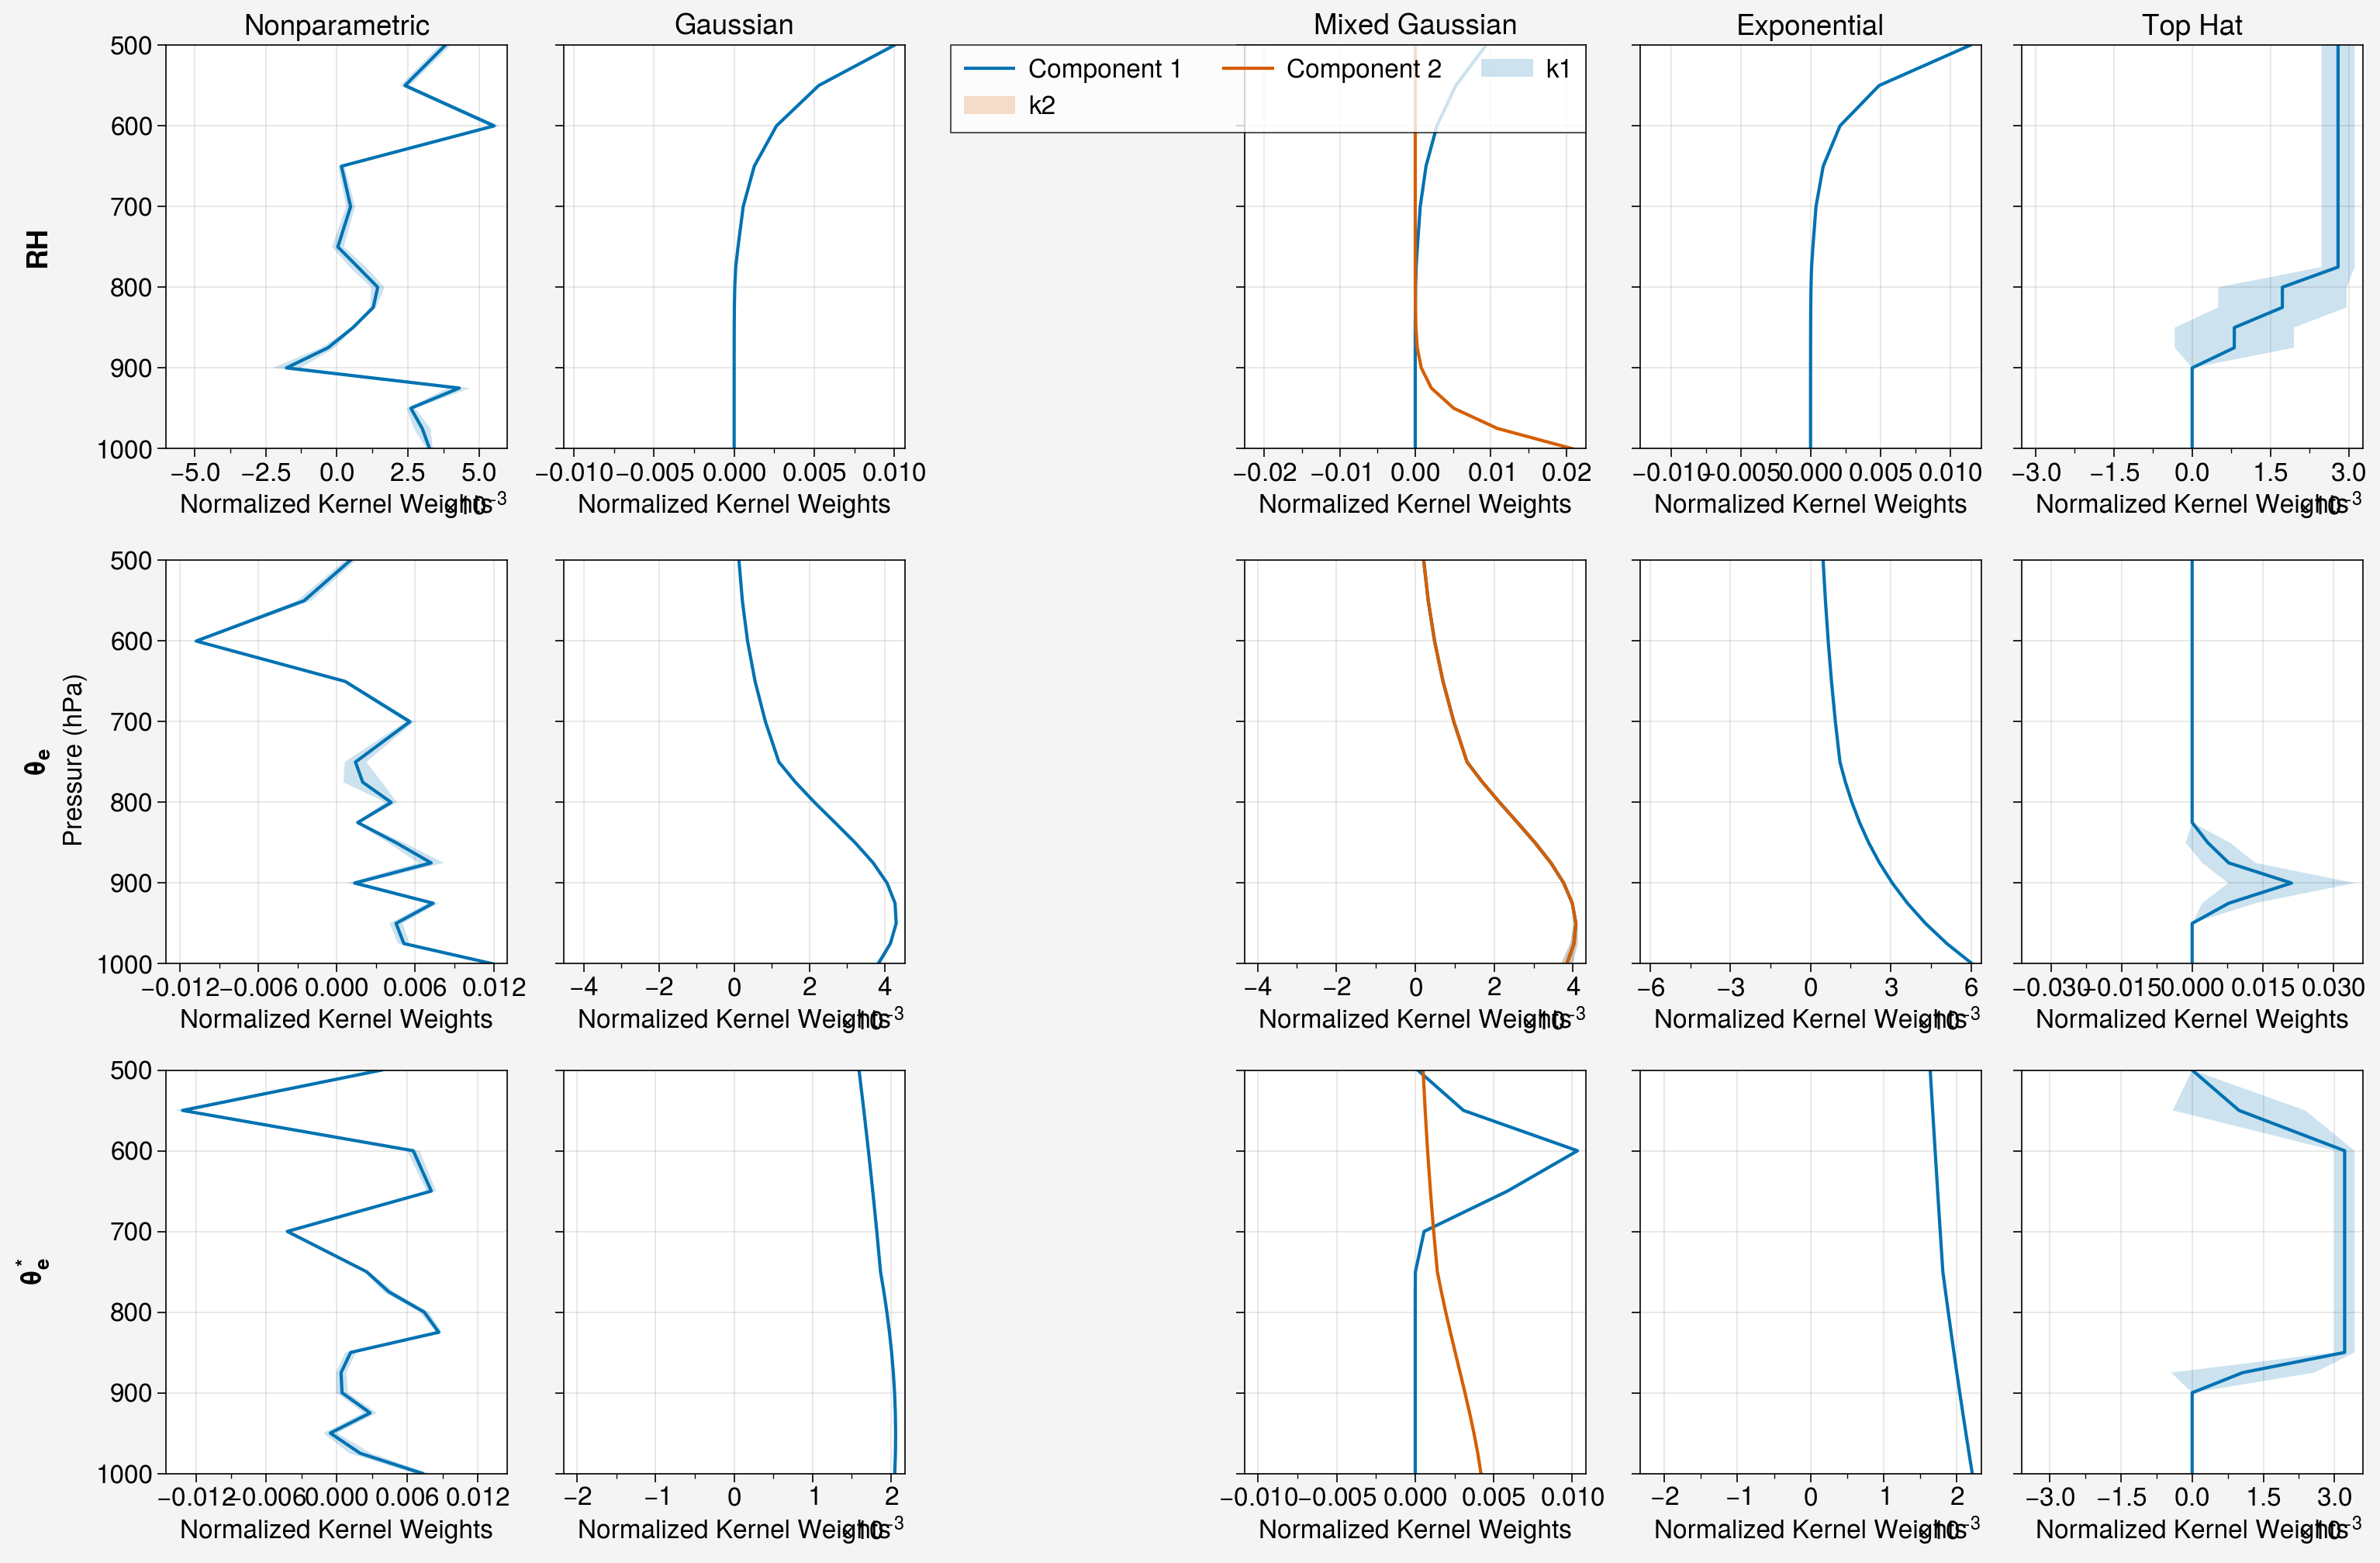

In [37]:
fig,axs = pplt.subplots(nrows=nrows,ncols=ncols,refwidth=2.2,refheight=2.6,sharex=False,sharey=True)
axs.format(xlabel='Normalized Kernel Weights',yreverse=True,ylabel='Pressure (hPa)',yminorticks='none',rowlabels=rowlabels)
for j,(family,title) in enumerate(families):
    axs[0,j].format(title=title)
    name = next((nm for nm in results if family in nm),None)
    if name is None:
        for i in range(nrows):
            axs[i,j].format(alpha=0.35)
        continue
    entry = results[name]
    for i in range(nrows):
        ax = axs[i,j]
        if entry['kind']=='mixture':
            mean1,std1 = entry['mean1'].isel(field=i),entry['std1'].isel(field=i)
            mean2,std2 = entry['mean2'].isel(field=i),entry['std2'].isel(field=i)
            ax.plot(mean1,lev,label='Component 1')
            ax.plot(mean2,lev,label='Component 2')
            ax.fill_betweenx(lev,mean1-std1,mean1+std1,alpha=0.2)
            ax.fill_betweenx(lev,mean2-std2,mean2+std2,alpha=0.2)
            if i==0:
                ax.legend(loc='ur')
        else:
            mean,std = entry['mean'].isel(field=i),entry['std'].isel(field=i)
            ax.plot(mean,lev)
            ax.fill_betweenx(lev,mean-std,mean+std,alpha=0.2)
        if entry['kind']=='mixture':
            values = [mean1.values,mean2.values,(mean1-std1).values,(mean1+std1).values,(mean2-std2).values,(mean2+std2).values]
        else:
            values = [mean.values,(mean-std).values,(mean+std).values]
        maxabs = max(float(np.nanmax(np.abs(value))) for value in values)
        maxabs = max(maxabs,1e-12)
        ax.format(xlim=(-1.05*maxabs,1.05*maxabs))
        ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=5))
        ax.xaxis.set_minor_locator(mticker.AutoMinorLocator(2))
        ax.xaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
        ax.ticklabel_format(axis='x',style='sci',scilimits=(-3,3))

pplt.show()
fig.save('../figs/weights.png')

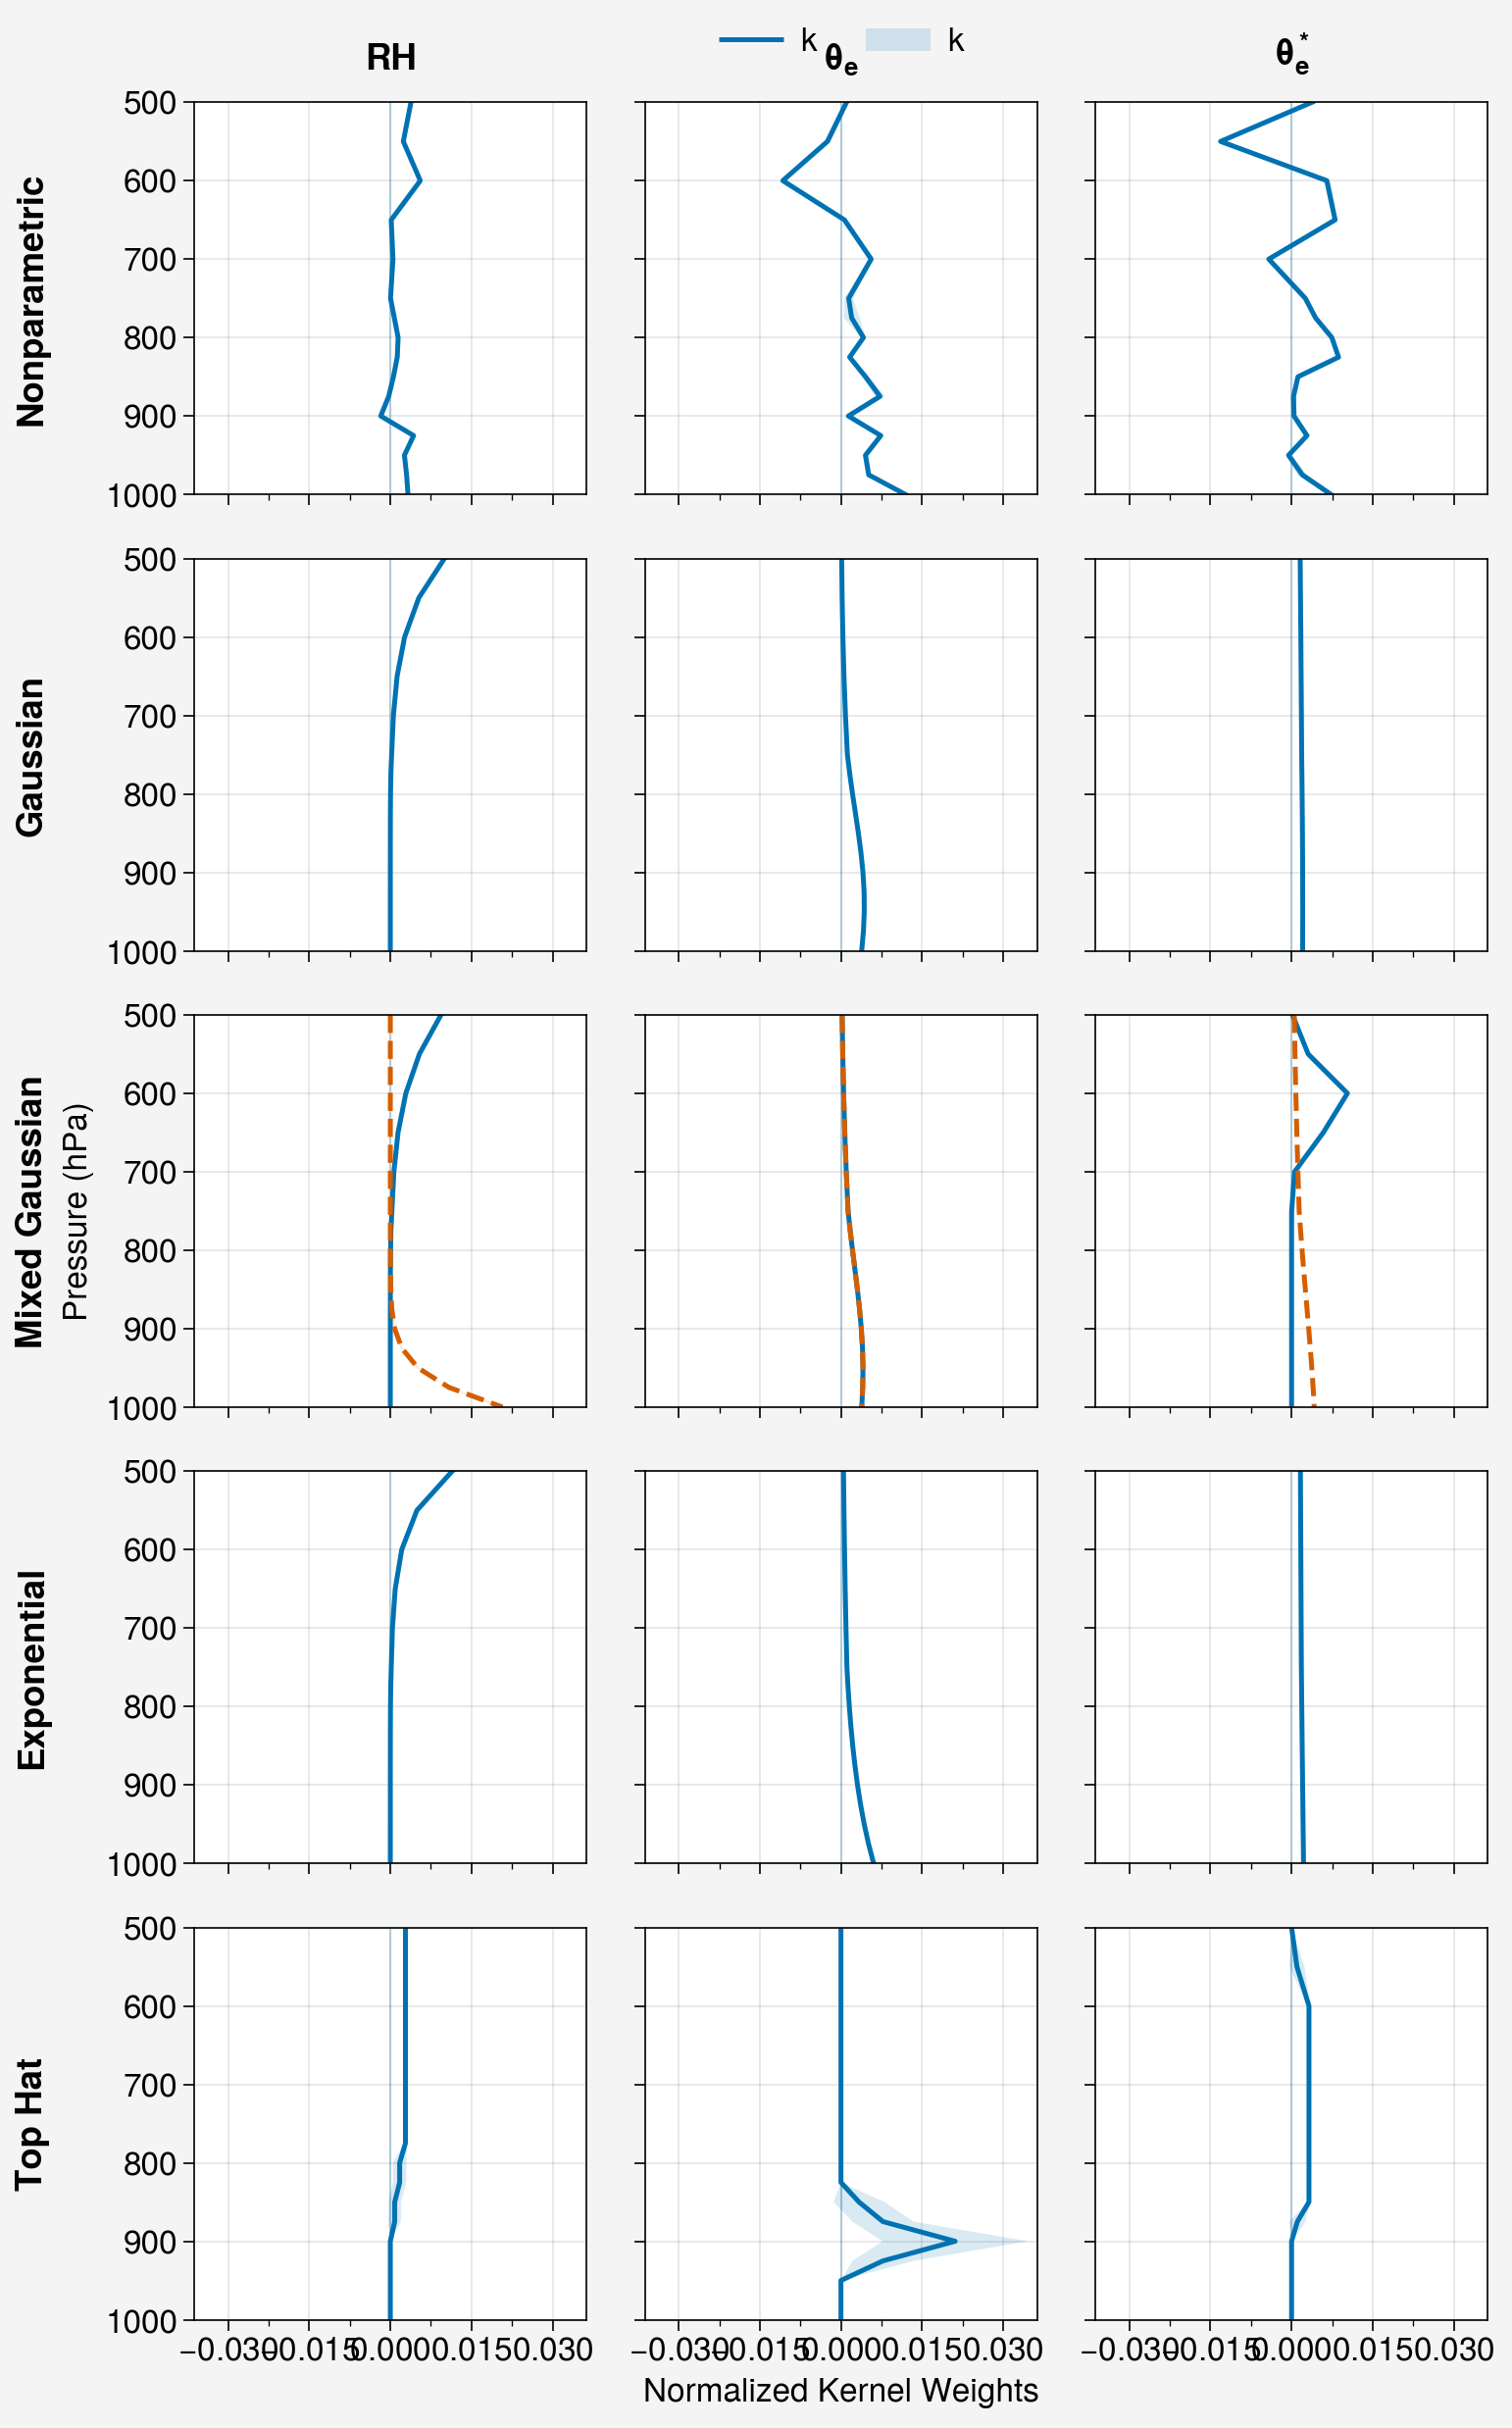

In [44]:
nrows,ncols = len(families),3
familylabels = [title for _,title in families] 

fig,axs = pplt.subplots(nrows=nrows,ncols=ncols,refwidth=2,refheight=2,sharex=True,sharey=True)

axs.format(collabels=rowlabels,rowlabels=familylabels,xlabel='Normalized Kernel Weights',
           yreverse=True,ylabel='Pressure (hPa)',yminorticks='none')

row_max = [0.0]*nrows

for r,(family,title) in enumerate(families):
    name = next((nm for nm in results if family in nm), None)
    if name is None:
        for c in range(ncols):
            axs[r,c].format(alpha=0.35)
        continue

    entry = results[name]
    for c in range(ncols):
        ax = axs[r,c]
        ax.axvline(0, lw=0.8, alpha=0.25)

        if entry['kind']=='mixture':
            mean1,std1 = entry['mean1'].isel(field=c),entry['std1'].isel(field=c)
            mean2,std2 = entry['mean2'].isel(field=c),entry['std2'].isel(field=c)
            ax.plot(mean1,lev,lw=1.8,label='Component 1')
            ax.plot(mean2,lev,lw=1.8,ls='--',label='Component 2')
            ax.fill_betweenx(lev,mean1-std1,mean1+std1,alpha=0.15)
            ax.fill_betweenx(lev,mean2-std2,mean2+std2,alpha=0.15)
            values = [mean1.values,mean2.values,(mean1-std1).values,(mean1+std1).values,
                      (mean2-std2).values,(mean2+std2).values]
        else:
            mean,std = entry['mean'].isel(field=c),entry['std'].isel(field=c)
            ax.plot(mean,lev,lw=1.8,label='k')
            ax.fill_betweenx(lev,mean-std,mean+std,alpha=0.15)
            values = [mean.values,(mean-std).values,(mean+std).values]

        maxabs = max(float(np.nanmax(np.abs(v))) for v in values)
        row_max[r] = max(row_max[r], max(maxabs, 1e-12))

        ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=5))
        ax.xaxis.set_minor_locator(mticker.AutoMinorLocator(2))
        ax.xaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-3,3))
        ax.xaxis.get_offset_text().set_fontsize(8)

# symmetric x-limits shared within each family row
for r in range(nrows):
    lim = 1.05*row_max[r]
    axs[r,:].format(xlim=(-lim, lim))

# single legend at top (grab first axis that has labels)
handles = labels = None
for ax in axs:
    h, l = ax.get_legend_handles_labels()
    if h:
        handles, labels = h, l
        break
if handles:
    fig.legend(handles, labels, loc='t', ncols=len(labels), frame=False)

pplt.show()
fig.save('../figs/weights.png', dpi=300)